In [15]:
import wandb
import cassava_utils as utils

import numpy as np
import pandas as pd
import os
from PIL import Image
import json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
# login for weights and biases for logging the training process
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
folderpath = "../input/cassava-leaf-disease-classification"
label2name_json = "../input/cassava-leaf-disease-classification/label_num_to_disease_map.json"
seed = 42

## Train/Val Split

In [11]:
df = pd.read_csv(os.path.join(folderpath, "train.csv"))

In [12]:
# only use some samples (e.g. for code testing, simple baseline or overfitting part)
df = df.iloc[:2500]

In [16]:
### Version 1: using just one train/val split with sklearn.train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, 
                                    random_state=seed)
#save dataframes as csv
train_df.to_csv("train_df.csv", index=False)
val_df.to_csv("val_df.csv", index=False)

In [7]:
### Version 2: using k-Fold cross validation with stratified k-folds
# from "Approaching almost all machine learning problems" by Abhishek Thaku

# we create a new column called kfold and fill it with -1
df["kfold"] = -1
# the next step is to randomize the rows of the data
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
 # fetch targets
y = df.label.values
# initiate the kfold class from model_selection module
kf = StratifiedKFold(n_splits=5)
# fill the new kfold column
for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f
# save the new csv with kfold column
df.to_csv("train_folds.csv", index=False)

## Sanity Check Dataloaders

In [8]:
# define simple transforms
def get_transforms(img_size):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(img_size),
            transforms.ToTensor()
        ]),
        'val': transforms.Compose([
            transforms.CenterCrop(img_size),
            transforms.ToTensor()
        ])
    }
    return data_transforms

In [9]:
# only look at fold 0
KFOLD = 0
# split into train and validation dataframes according to KFOLD
df = pd.read_csv("train_folds.csv")
dfs = {
    "train": df[df.kfold != KFOLD].reset_index(drop=True),
    "val": df[df.kfold == KFOLD].reset_index(drop=True)
}

datasets = {x: utils.CassavaDataset(dfs[x],
                                    os.path.join(folderpath,"train_images"),
                                    transforms=get_transforms(224)[x])
            for x in ["train", "val"]}

dataloaders = {x: DataLoader(datasets[x], batch_size=32,
                             num_workers=4, shuffle=x=="train")
               for x in ["train", "val"]}

Label: tensor(3)


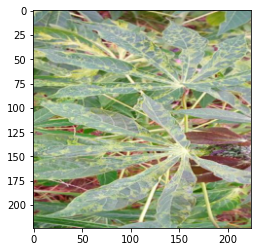

In [10]:
utils.check_dataloaders(dataloaders)

# Simple Model Baseline

In [11]:
DEVICE = "cuda"
# just use one fold
FOLD = 0

In [14]:
def run_training_simplenet(fold, save_model=False):
    # wandb preferences (configurations and initialization)
    config_defaults = {
        "lr": 1e-3,
        "epochs": 5,
        "img_size": 224
    }
    wandb.init(project="cassava", config=config_defaults)
    config = wandb.config
    
    # split into train and validation dataframes according to fold parameter
    df = pd.read_csv("train_folds.csv")
    dfs = {
        "train": df[df.kfold != fold].reset_index(drop=True),
        "val": df[df.kfold == fold].reset_index(drop=True)
    }
    
    datasets = {x: utils.CassavaDataset(dfs[x],
                                        os.path.join(folderpath,"train_images"),
                                        transforms=get_transforms(config.img_size)[x])
                for x in ["train", "val"]}
    
    dataloaders = {x: DataLoader(datasets[x], batch_size=16,
                                 num_workers=8, shuffle=x=="train")
                   for x in ["train", "val"]}
    
    model = utils.SimpleNet()
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    eng = utils.Engine(model, optimizer, device=DEVICE)
    
    best_loss = np.inf
    
    for epoch in range(config.epochs):
        train_loss = eng.train(dataloaders["train"])
        val_loss, val_acc = eng.evaluate(dataloaders["val"])
        print('Fold {} epoch [{}/{}] train loss: {:.4f} ' 
                  'valid loss: {:.4f} acc: {:.4f}'.format(
                      fold, epoch+1, config.epochs, 
                      train_loss, val_loss, val_acc))
        if val_loss < best_loss:
            best_loss = val_loss
            if save_model:
                torch.save(model, f"model_{fold}.pth")
    return best_loss

In [15]:
### uncomment line below to run training
# run_training_simplenet(FOLD)

wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 0 epoch [1/5] train loss: 1.1963 valid loss: 1.0700 acc: 0.6160
Fold 0 epoch [2/5] train loss: 1.1714 valid loss: 1.1216 acc: 0.6160
Fold 0 epoch [3/5] train loss: 1.1437 valid loss: 1.1631 acc: 0.6220
Fold 0 epoch [4/5] train loss: 1.1159 valid loss: 1.0803 acc: 0.6320
Fold 0 epoch [5/5] train loss: 1.1188 valid loss: 1.0472 acc: 0.6200


1.0471558617427945

Insights:
We ran different experiments on the simple baseline model and check if we have any bugs in our code and to learn more about the data (inspired by Karpathy's blog post "A recipe for training neural networks") 
* Input-independent baseline: set the input to all zero to check that our model extracts any information out of the input during training --> check!
* Overfit one batch: we tried to reach zero training loss by training only on one batch --> check!
* Verify decreasing training loss: increased the model capacity (bigger hidden layers) and saw that training loss goes down --> check!

# Overfit

In [16]:
DEVICE = "cuda"

In [17]:
def run_training_overfit(fold, watch_model=False, save_model=False):
    #wandb preferences (configurations and initialization)
    config_defaults = {
        "lr": 2.85e-4,
        "epochs": 15,
        "img_size": 400
    }
    wandb.init(project="cassava", config=config_defaults)
    config = wandb.config
    
    # split into train and validation dataframes according to fold parameter
    df = pd.read_csv("train_folds.csv")
    dfs = {
        "train": df[df.kfold != fold].reset_index(drop=True),
        "val": df[df.kfold == fold].reset_index(drop=True)
    }
    
    datasets = {x: utils.CassavaDataset(dfs[x],
                                        os.path.join(folderpath,"train_images"),
                                        transforms=get_transforms(config.img_size)[x])
                for x in ["train", "val"]}

    dataloaders = {x: DataLoader(datasets[x], batch_size=16,
                                 num_workers=8, shuffle=x=="train")
                   for x in ["train", "val"]}
    
    model = utils.create_model_layer4(DEVICE, pretrained=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    eng = utils.Engine(model, optimizer, device=DEVICE)
    
    best_loss = np.inf
    
    if watch_model:
        wandb.watch(model, log="all")
    
    for epoch in range(config.epochs):
        train_loss = eng.train(dataloaders["train"])
        val_loss, val_acc = eng.evaluate(dataloaders["val"])
        print('Epoch [{}/{}] train loss: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch+1, config.epochs, train_loss, 
                val_loss, val_acc))
        if val_loss < best_loss:
            best_loss = val_loss
            if save_model:
                torch.save(model, f"model_{fold}.pth")
        wandb.log({
            "Training loss": train_loss,
            "Validation loss": val_loss,
            "Accuracy": val_acc 
        })
    return best_loss

In [18]:
### uncomment line below to run training
# run training on 5 folds and output the average loss
# losses = 0
# for fold in range(5):
#     loss_temp = run_training_overfit(fold)
#     losses += loss_temp
# print ("Final loss over all 5 folds is:", str(losses / 5))

wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Epoch [1/15] train loss: 0.7863 valid loss: 0.6572 acc: 0.7660
Epoch [2/15] train loss: 0.6270 valid loss: 0.5324 acc: 0.8120


KeyboardInterrupt: 

# Regularization


In [19]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [20]:
data_albums = {
    'train': A.Compose([
        A.RandomResizedCrop(height=400, width=400),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()]),
    'val': A. Compose([
        A.Resize(height=400, width=400),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()])}

Label: tensor(3)


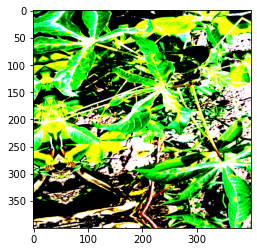

In [21]:
# check dataloaders
FOLD = 0

df = pd.read_csv("train_folds.csv")
dfs = {
    "train": df[df.kfold != FOLD].reset_index(drop=True),
    "val": df[df.kfold == FOLD].reset_index(drop=True)
}

datasets = {x: utils.CassavaDataset(dfs[x],
                                    os.path.join(folderpath,"train_images"),
                                    albums=data_albums[x])
            for x in ["train", "val"]}

dataloaders = {x: DataLoader(datasets[x], batch_size=16,
                             num_workers=8, shuffle=x=="train")
               for x in ["train", "val"]}

utils.check_dataloaders(dataloaders, index=10)

In [22]:
def run_training_regularization(fold, watch_model=False, save_model=False):
    # wandb preferences (configurations and initialization)
    config_defaults = {
        "lr": 1e-4,
        "epochs": 15,
        "step_size": 7,
        "gamma": 0.2
    }
    wandb.init(project="cassava", config=config_defaults)
    config = wandb.config
    
    # load csv data and split in train/val according to the fold parameter
    df = pd.read_csv("train_folds.csv")
    dfs = {
        "train": df[df.kfold != fold].reset_index(drop=True),
        "val": df[df.kfold == fold].reset_index(drop=True)
    }
    
    # define datasets and dataloaders with helper functions of utils.py 
    datasets = {x: utils.CassavaDataset(dfs[x],
                                        os.path.join(folderpath,"train_images"),
                                        albums=data_albums[x])
                for x in ["train", "val"]}

    dataloaders = {x: DataLoader(datasets[x], batch_size=16,
                                 num_workers=8, shuffle=x=="train")
                   for x in ["train", "val"]}
    
    # initialize model, optimizer, engine and lr scheduler
    model = utils.create_model_layer4(DEVICE, pretrained=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    eng = utils.Engine(model, optimizer, device=DEVICE)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
    
    if watch_model:
        wandb.watch(model, log="all")
    
    # training loop
    best_loss = np.inf    
    
    for epoch in range(config.epochs):
        train_loss = eng.train(dataloaders["train"])
        val_loss, val_acc = eng.evaluate(dataloaders["val"])
        print('Epoch [{}/{}] train loss: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch+1, config.epochs, train_loss, 
                val_loss, val_acc))
        if val_loss < best_loss:
            best_loss = val_loss
            if save_model:
                torch.save(model, f"model_{fold}.pth")
                wandb.save(f"model_{fold}.pth")

        wandb.log({
            "Training loss": train_loss,
            "Validation loss": val_loss,
            "Accuracy": val_acc,
            "Learning_rate": optimizer.state_dict()["param_groups"][0]["lr"]
        })
        scheduler.step()
    return best_loss

In [23]:
### uncomment line below to run training
# run training on 5 folds and output the average loss
# losses = 0
# for fold in range(5):
#     loss_temp = run_training_regularization(fold, save_model=True)
#     losses += loss_temp
# print ("Final loss over all 5 folds is:", str(losses / 5))

Training loss,0.62696
Validation loss,0.53236
Accuracy,0.812
_step,1
_runtime,71
_timestamp,1614189443


Training loss,█▁
Validation loss,█▁
Accuracy,▁█
_step,▁█
_runtime,▁█
_timestamp,▁█


wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch [1/15] train loss: 0.7867 valid loss: 0.5837 acc: 0.8180


KeyboardInterrupt: 

## LR Finder

In [ ]:
pip install torch-lr-finder

In [ ]:
from torch_lr_finder import LRFinder

In [ ]:
def use_lr_finder():
    # used infos on https://pypi.org/project/torch-lr-finder/
    wandb.init(project="cassava")
    # only use one fold
    FOLD = 0
    
    # load csv data and split in train/val according to the fold parameter
    df = pd.read_csv("train_folds.csv")
    dfs = {
        "train": df[df.kfold != FOLD].reset_index(drop=True),
        "val": df[df.kfold == FOLD].reset_index(drop=True)
    }

    datasets = {x: utils.CassavaDataset(dfs[x],
                                        os.path.join(folderpath,"train_images"),
                                        albums=data_albums[x])
                for x in ["train", "val"]}

    dataloaders = {x: DataLoader(datasets[x], batch_size=16,
                                 num_workers=8, shuffle=x=="train")
                   for x in ["train", "val"]}
    
    model = utils.create_model_layer4(DEVICE, pretrained=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
    lr_finder = LRFinder(model, optimizer, criterion, device=DEVICE)
    lr_finder.range_test(dataloaders["train"], end_lr=100, num_iter=100)
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
### uncomment to run learning rate finder
# use_lr_finder()

# Evaluate predictions with confusion matrix

Evaluates the predictions of one model, which was trained above on training data, on unseen validation data.

In [1]:
DEVICE = 'cuda'

In [2]:
import json
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
model_path = "../input/resnet50/model (1).pth"
label2name_json = "../input/cassava-leaf-disease-classification/label_num_to_disease_map.json"

In [4]:
data_albums = {
    'test': A.Compose([
        A.Resize(height=400, width=400),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()])}

In [5]:
def create_test_dataloader(dataframe, root_dir, data_albums):
    test_files = np.asarray(dataframe.iloc[:,0])
    test_dataset = utils.CassavaTestDataset(test_files, root_dir, albums=data_albums["test"])
    test_dataloader = {"test": DataLoader(test_dataset, batch_size=16, num_workers=8)}
    return test_dataloader

In [17]:
root_dir = os.path.join(folderpath, "train_images")
val_df = pd.read_csv("./val_df.csv")

val_dataloader = create_test_dataloader(val_df, root_dir, data_albums)

In [18]:
model = torch.load(model_path)

In [19]:
def get_inference_df(dataloader, model, device):
    test_eng = utils.Engine(model, optimizer=None, device=device)
    inference_df = test_eng.predict(dataloader["test"])
    return inference_df 

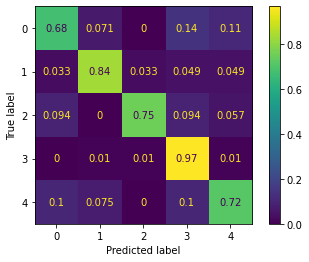

In [21]:
# get predictions for validation data
val_preds_df = get_inference_df(val_dataloader, model, DEVICE)
val_preds = val_preds_df.iloc[:,1]

# get labels for validation data
val_labels = val_df.iloc[:,1]

# get confusion matrix
conf_mat = confusion_matrix(val_labels, val_preds, normalize="true")

# display confusion matrix
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot();